# EDA: CancerModels.Org Data Assessment

In [1]:
import pandas as pd
from tqdm import tqdm
from utils import read_metadata_without_fields, get_files, get_dirs, read_metadata_with_fields
from pandas import read_csv, DataFrame, concat
from os.path import join, dirname, exists
from time import ctime, time
from subprocess import run, check_output, CalledProcessError
import seaborn as sns
import logging


logging.basicConfig(filename='{}.log'.format('data_overview_file_generation'), filemode='a+', level=logging.DEBUG)

In [2]:
def get_git_tags():
    try:
        tags = check_output([f'cd {home}; git tag'], shell=True, text=True).splitlines()
        return [t for t in tags if t.__contains__('PDCM')]
    except CalledProcessError as e:
        print("Error:", e)
        return None

def checkout_and_run_function(tag):
    try:
        logging.info(f"{ctime()}: Running pipeline for tag: {tag}")
        run([f'cd {home}; git checkout {tag}'], shell=True, check=True)
        mol_data, total_models = get_mol_data(home)
        mol_data.to_csv(f"{str(git_tags[tag]).replace('PDCM_', '')}.csv", index=False)
        total_models.to_csv(f"total_models_{str(git_tags[tag]).replace('PDCM_', '')}.csv", index=False)
    except CalledProcessError as e:
        print("Error:", e)

In [3]:
home = "/Users/tushar/CancerModels/pdxfinder-data/data/UPDOG"
data_types = ['mut', 'cna', 'expression', 'immunemarker', 'biomarker', 'images', 'cyto']

## EDA 1: Data overview
- Percentage of models that have data based on the data types
- Data types based on the protocol used
- Data types based on the technology (Platform used)

In [4]:
def get_mol_data(home):
    cm_providers = sorted(get_dirs(home))
    mol_data = DataFrame()
    total_model = DataFrame()
    for pro_num in tqdm(range(len(cm_providers)), "Generating data for analysis"):
        provider = cm_providers[pro_num]
        logging.info(f"{ctime()}: Processing: {provider}")
        provider_path = join(home, provider)
        if not exists(join(provider_path, f'{provider}_metadata-patient_sample.tsv')):
            logging.info(f"{ctime()}: {provider}: Patient sample missing.")
            continue
        if not (exists(join(provider_path, f'{provider}_metadata-pdx_model.tsv')) or 
                exists(join(provider_path, f'{provider}_metadata-cell_model.tsv'))):
            logging.info(f"{ctime()}: {provider}: Model sheet missing.")
            continue
        start = time()
        provider_mol_data = DataFrame()
        provider_data_types = get_dirs(provider_path)
        model = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-patient_sample.tsv'))
        patient = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-patient.tsv'))[['patient_id', 'sex', 'ethnicity']]
        patient['patient_id'] = patient['patient_id'].astype(str)
        model['patient_id'] = model['patient_id'].astype(str)
        model = model.merge(patient, on ='patient_id', how='left')
        model_temp = DataFrame()
        if exists(join(provider_path, f'{provider}_metadata-pdx_model.tsv')):
            pdx = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-pdx_model.tsv'))[['model_id', 'publications']]
            pdx['model_type'] = 'PDX'
            model_temp = pd.concat([model_temp, pdx[['model_id', 'model_type', 'publications']]])
        if exists(join(provider_path, f'{provider}_metadata-cell_model.tsv')): 
            cell = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-cell_model.tsv'))[['model_id', 'type', 'publications']]
            cell['model_type'] = cell['type']
            model_temp = pd.concat([model_temp, cell[['model_id', 'model_type', 'publications']]]) 
        model = model.merge(model_temp, on='model_id', how='left')
        model['provider'] = provider
        model = model.drop_duplicates(['model_id'])
        total_model = concat([total_model, model[['model_id', 'provider', 'model_type', 'publications', 'age_in_years_at_collection', 'diagnosis', 'tumour_type', 'primary_site', 'sex', 'ethnicity']]]).reset_index(drop=True)
        for data_type in data_types:
            if data_type in provider_data_types:
                data_path = join(provider_path, data_type)
                files = [f for f in get_files(data_path) if f.endswith('.tsv')]
                if len(files)==0:
                    dirs = get_dirs(data_path)
                    files = list()
                    for dir in dirs:
                        f = get_files(join(data_path, dir))
                        f = [join(dir, i) for i in f if i.endswith('.tsv')]
                        files.append(f)
                    files = [item for sublist in files for item in sublist]
                for file_name in files:
                    temp = read_csv(join(data_path, file_name), sep='\t', usecols=['sample_id', 'platform_id'])
                    temp = temp.drop_duplicates()
                    if data_type == 'cyto':
                        data_type = 'biomarker'
                    temp['type'] = data_type
                    temp['provider'] = provider
                    provider_mol_data = concat([provider_mol_data, temp]).reset_index(drop=True) 
        if len(provider_mol_data) > 0:
            platform = read_metadata_without_fields(join(provider_path, f'{provider}_molecular_metadata-platform.tsv'))[['platform_id','molecular_characterisation_type','instrument_model','library_strategy']]
            platform['molecular_characterisation_type'] = platform['molecular_characterisation_type'].str.replace('cytogenetics', 'biomarker') 
            sample = read_metadata_without_fields(join(provider_path, f'{provider}_molecular_metadata-sample.tsv'))
            sample = sample[['platform_id','model_id','sample_id']]
            sample['sample_id'] = sample['sample_id'].astype(str) 
            provider_mol_data['sample_id'] = provider_mol_data['sample_id'].astype(str) 
            mol_data = concat([mol_data, provider_mol_data.merge(platform, on='platform_id', how='left').merge(sample, on='sample_id', how='left')]).reset_index(drop=True)
        if f'{provider}_metadata-model_image.tsv' in get_files(provider_path):
            images = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-model_image.tsv'))
            images['provider'] = provider
            images['type'] = 'images'
            images['molecular_characterisation_type'] = 'images'
            images = images[['model_id', 'provider', 'type', 'molecular_characterisation_type']].drop_duplicates()
            for col in mol_data.columns:
                if col not in images.columns:
                    images[col] = ""
            mol_data = concat([mol_data, images]).reset_index(drop=True)
        if 'treatment' in get_dirs(provider_path):
            treatment = read_metadata_with_fields(join(provider_path, f'treatment/{provider}_patienttreatment-Sheet1.tsv'))
            treatment = treatment[['patient_id']].drop_duplicates().merge(model.drop_duplicates(['patient_id']), on='patient_id', how='left')
            treatment['provider'] = provider
            treatment['type'] = 'treatment'
            treatment['molecular_characterisation_type'] = 'treatment'
            treatment = treatment[['model_id', 'provider', 'type', 'molecular_characterisation_type', 'sample_id']].drop_duplicates()
            for col in mol_data.columns:
                if col not in treatment.columns:
                    treatment[col] = ""
            mol_data = concat([mol_data, treatment]).reset_index(drop=True)
        if 'drug' in get_dirs(provider_path):
            drug = read_metadata_with_fields(join(provider_path, f'drug/{provider}_drugdosing-Sheet1.tsv'))
            drug = drug.drop_duplicates(['model_id'])
            drug['provider'] = provider
            drug['type'] = 'drug'
            drug['molecular_characterisation_type'] = 'drug'
            drug = drug[['model_id', 'provider', 'type', 'molecular_characterisation_type']].drop_duplicates()
            for col in mol_data.columns:
                if col not in drug.columns:
                    drug[col] = ""
            mol_data = concat([mol_data, drug]).reset_index(drop=True)
        logging.info(f"{ctime()}: {provider}: took {round(time()-start, 2)} secs")
    return mol_data, total_model

In [5]:
current_dir = check_output('pwd', shell=True, text=True)[:-1]
git_tags = {'00f46821': 'PDCM_DR_v1.0', 'e2e44469': 'PDCM_DR_v2.0', 
            'fcd095df': 'PDCM_DR_v2.1', '041be7d2': 'PDCM_DR_v3.0', 
            '597fd689': 'PDCM_DR_v3.1', 'cfb23e3c': 'PDCM_DR_v4.0', 
            'b4f0203a': 'PDCM_DR_v5.0', '2e67bc5e': 'PDCM_DR_v5.1',
            '3b29259f': 'PDCM_DR_v5.2', 'c3c428a3': 'PDCM_DR_v5.3'}#get_git_tags()
for tag in git_tags.keys():
    checkout_and_run_function(tag)

Note: switching to '00f46821'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 00f46821 Merge branch 'dev' of https://gitlab.ebi.ac.uk/mouse-informatics/pdxfinder-data into dev
Generating data for analysis:  60%|██████    | 24/40 [01:38<00:28,  1.79s/it]/var/folders/_2/g5d3zf4s41g0tvlqkc3_8wjr0000gp/T/ipykernel_4393/803642060.py:50: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = read_csv(join(data_path, file_name), sep='\t', usecols=['sample_id', 'pl

In [91]:
#mol_data.to_csv('DR_v5.2.csv', index=False)

### Missing

In [80]:
total_model.shape[0]

7174

In [70]:
mol_data

,sample_id,platform_id_x,type,provider,molecular_characterisation_type,instrument_model,library_strategy,platform_id_y,model_id
0,Oncotest-R0026,mutation_RNA_sequencing,mut,CRL,mutation,RNA sequencing,rna sequencing,mutation_RNA_sequencing,CRL-546
1,Oncotest-R0026,mutation_RNA_sequencing,mut,CRL,mutation,RNA sequencing,rna sequencing,expression_ILLUMINA,CRL-546
2,Oncotest-R0074,mutation_RNA_sequencing,mut,CRL,mutation,RNA sequencing,rna sequencing,mutation_RNA_sequencing,CRL-3039
3,Oncotest-R0074,mutation_RNA_sequencing,mut,CRL,mutation,RNA sequencing,rna sequencing,expression_ILLUMINA,CRL-3039
4,Oncotest-R0042,mutation_RNA_sequencing,mut,CRL,mutation,RNA sequencing,rna sequencing,mutation_RNA_sequencing,CRL-2131
...,...,...,...,...,...,...,...,...,...
17226,BC173P0_1642,cytogenetics_immunohistochemistry,biomarker,VHIO-BC,biomarker,immunohistochemistry,immunohistochemistry,cytogenetics_immunohistochemistry,VHIO_BC173
17227,HGP379.1 TUMOR CTAX2X11,mutation_WES,mut,VHIO-CRC,mutation,WES,Whole exome sequencing,mutation_WES,CTAX002
17228,HGP397.1 TUMOR CTAX3X5,mutation_WES,mut,VHIO-CRC,mutation,WES,Whole exome sequencing,mutation_WES,CTAX003
17229,HGP403.1 TUMOR M42X3,mutation_WES,mut,VHIO-CRC,mutation,WES,Whole exome sequencing,mutation_WES,M042


In [6]:
(mol_data[mol_data['platform_id_y'].isna()].shape[0]/mol_data.shape[0])*100

0.03489080651819236

In [96]:
mol_data.groupby('type').count()['model_id']

type
biomarker        1152
cna             13420
drug              608
expression      14732
images           1203
immunemarker    82802
mut             20907
treatment         503
Name: model_id, dtype: int64

In [97]:
mol_data.drop_duplicates(['model_id', 'molecular_characterisation_type']).groupby('molecular_characterisation_type').count()['model_id']

molecular_characterisation_type
biomarker                  337
copy number alteration    2693
drug                       607
expression                2983
images                    1203
immunemarker              2662
mutation                  4093
treatment                  503
Name: model_id, dtype: int64

In [9]:
data_type_numbers = mol_data.drop_duplicates(['model_id', 'type']).groupby('type').count()/total_model.shape[0]*100
data_type_numbers['molecular_characterisation_type']

type
biomarker        3.972651
cna             33.855947
drug             7.155487
expression      55.381351
images          23.989155
immunemarker    34.775433
mut             57.562183
treatment        5.941294
Name: molecular_characterisation_type, dtype: float64

In [10]:
mol_data.drop_duplicates(['model_id', 'type']).groupby(['type','library_strategy']).count()['molecular_characterisation_type']['mut']

library_strategy
RNA-Seq                 343
Targeted NGS             15
Targeted Sequencing       1
Targeted capture        568
WES                    3134
WGS                     184
WXS                     285
Name: molecular_characterisation_type, dtype: int64

In [11]:
mol_data.drop_duplicates(['model_id', 'type']).groupby(['type','library_strategy']).count()['molecular_characterisation_type']['expression']

library_strategy
RNA-Seq       3571
mRNA NGS        28
microarray     666
Name: molecular_characterisation_type, dtype: int64

In [12]:
mol_data.drop_duplicates(['model_id', 'type']).groupby(['type','library_strategy']).count()['molecular_characterisation_type']['cna']

library_strategy
Targeted capture     299
WES                  240
WGS                 1520
microarray           513
Name: molecular_characterisation_type, dtype: int64

In [13]:
mol_data.drop_duplicates(['model_id', 'type']).groupby(['type','instrument_model']).count()['molecular_characterisation_type']

type       instrument_model    
biomarker  FISH                      6
           IHC                     142
           ISH/CISH/FISH             7
           Immunohistochemistry     41
           NORLUX IHC                5
                                  ... 
mut        RNA sequencing          343
           TEX_DFCI                 16
           Truseq_JAX               45
           Whole_Exome              31
treatment                          504
Name: molecular_characterisation_type, Length: 64, dtype: int64

In [14]:
model_molecular_types = mol_data.groupby('molecular_characterisation_type')['model_id'].apply(set)
model_molecular_types

molecular_characterisation_type
biomarker                 {HCM-BROD-0013-C71, CAM2004T2, HCM-CSHL-1097-C...
copy number alteration    {CRL-3011, nan, PHLC189, PHLC192, HCM-BROD-013...
drug                      {NIBRX-2239, TM00208, NIBRX-1855, NIBRX-4538, ...
expression                {CRL-3011, 616732-234-R1, CRL-OV-003, SIDM0064...
images                    {CRL-3011, nan, TM00281, HCM-BROD-0013-C71, CR...
immunemarker              {CRL-OV-003, SIDM00644, SIDM00751, CRL-2601, S...
mutation                  {CRL-3011, nan, K42656-251-R, PHLC189, PHLC192...
treatment                 {nan, T188, 628479-137-R10, 253994-281-T, 9261...
Name: model_id, dtype: object

In [50]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
from seaborn import color_palette


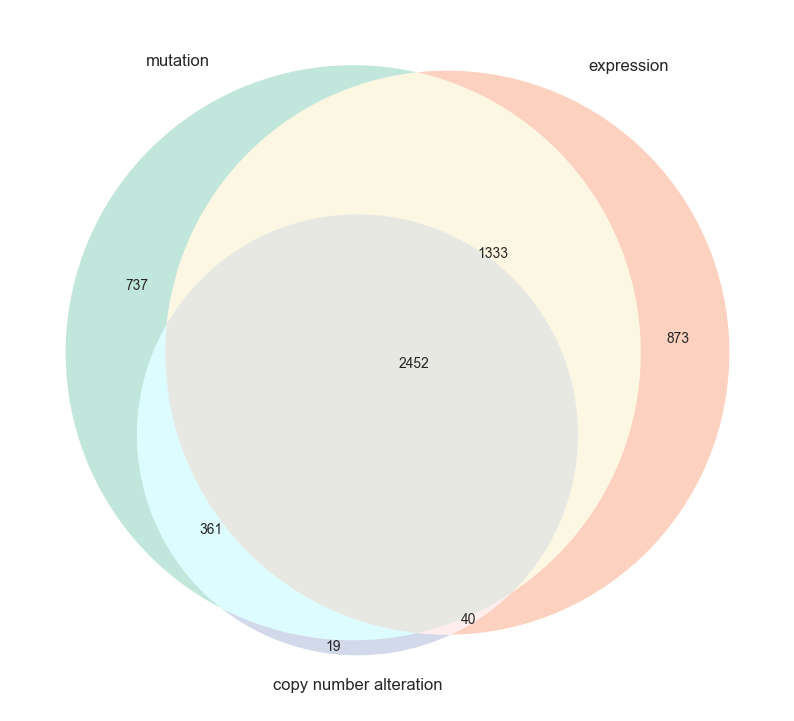

In [72]:
plt.figure(figsize=(10,10))
venn3([set(model_molecular_types['mutation']), 
       set(model_molecular_types['expression']), 
       set(model_molecular_types['copy number alteration'])],
      set_labels=('mutation', 'expression', 'copy number alteration'), set_colors=color_palette('Set2'))
plt.show()

In [21]:
characterised_models = set(model_molecular_types['mutation']).intersection(set(model_molecular_types['expression']), set(model_molecular_types['copy number alteration']))

In [18]:
DataFrame(characterised_models)

,0
0,AB521M1
1,AB551M1
2,AB559
3,AB580
4,ALL-02
...,...
2447,TM01634
2448,immune_mpm
2449,immune_msi
2450,immune_ploidy_snp6


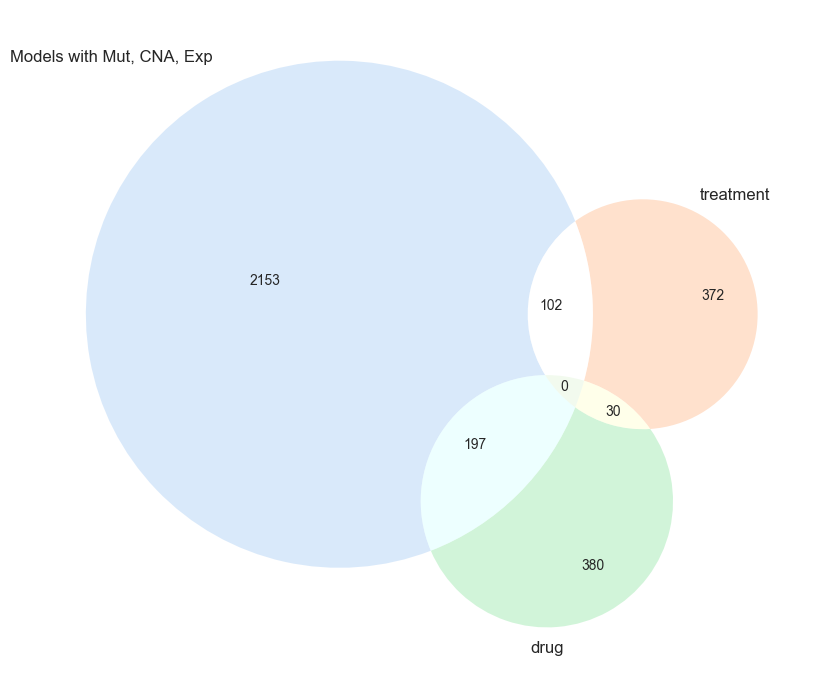

In [22]:
plt.figure(figsize=(10,10))
venn3([characterised_models, 
       set(model_molecular_types['treatment']), 
       set(model_molecular_types['drug'])],
      set_labels=('Models with Mut, CNA, Exp', 'treatment', 'drug'), set_colors=color_palette('pastel'))
plt.show()

In [23]:
DataFrame(sorted(characterised_models.intersection(set(model_molecular_types['drug']))))

,0
0,CRC0014LM
1,CRC0018LM
2,CRC0025LM
3,CRC0029LM
4,CRC0030LM
...,...
192,TM01273
193,TM01278
194,TM01353
195,TM01563


In [24]:
DataFrame(sorted(characterised_models.intersection(set(model_molecular_types['treatment']))))

,0
0,AB551M1
1,AB559
2,AB580
3,ALL-02
4,ALL-03
...,...
97,T188
98,T192
99,T347
100,T394


In [48]:
from venn import pseudovenn

<Axes: >

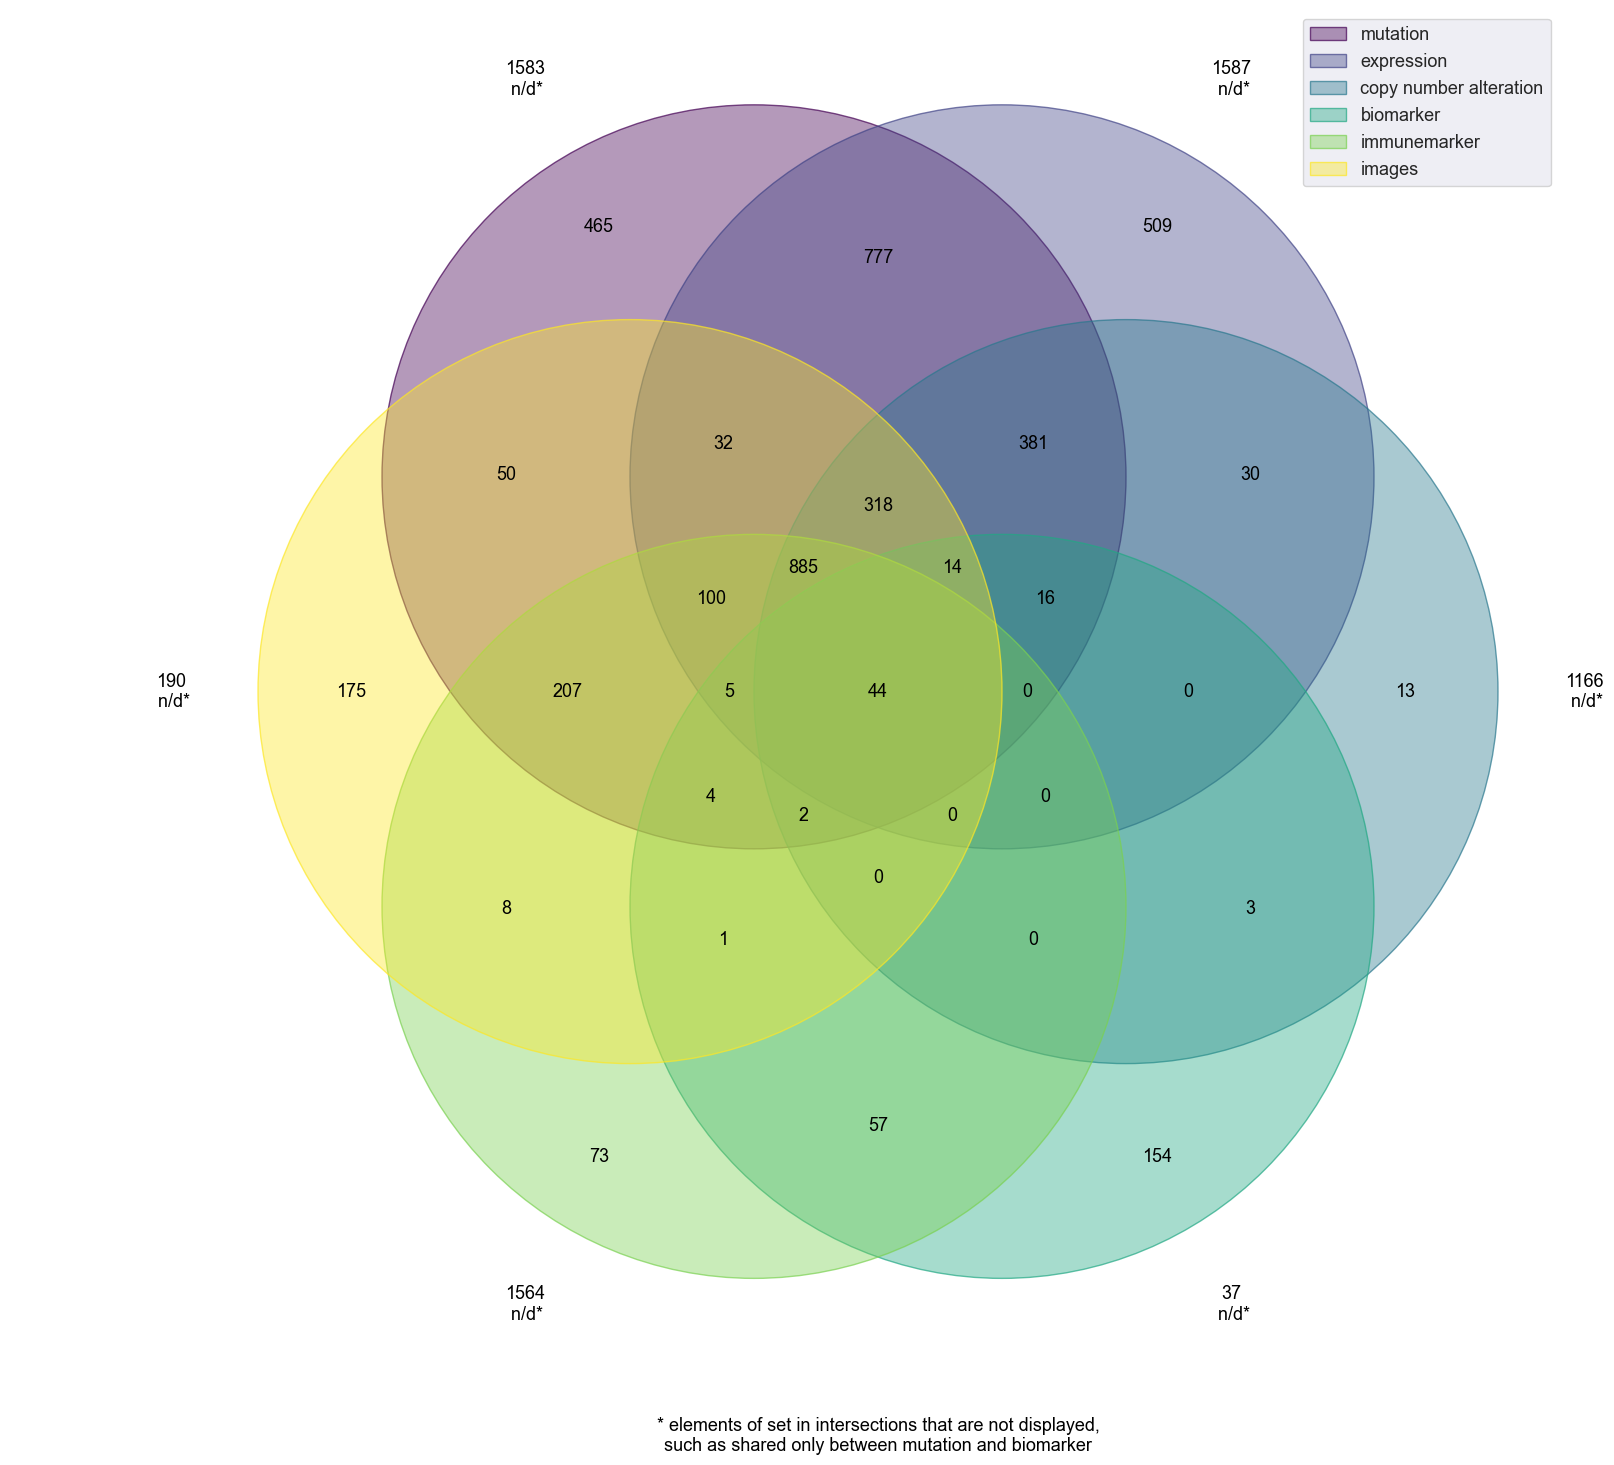

In [26]:
pseudovenn({'mutation': set(model_molecular_types['mutation']), 
       'expression': set(model_molecular_types['expression']), 
       'copy number alteration': set(model_molecular_types['copy number alteration']), 
       'biomarker': set(model_molecular_types['biomarker']), 
       'immunemarker': set(model_molecular_types['immunemarker']), 
       'images': set(model_molecular_types['images'])}, figsize=(20, 20))


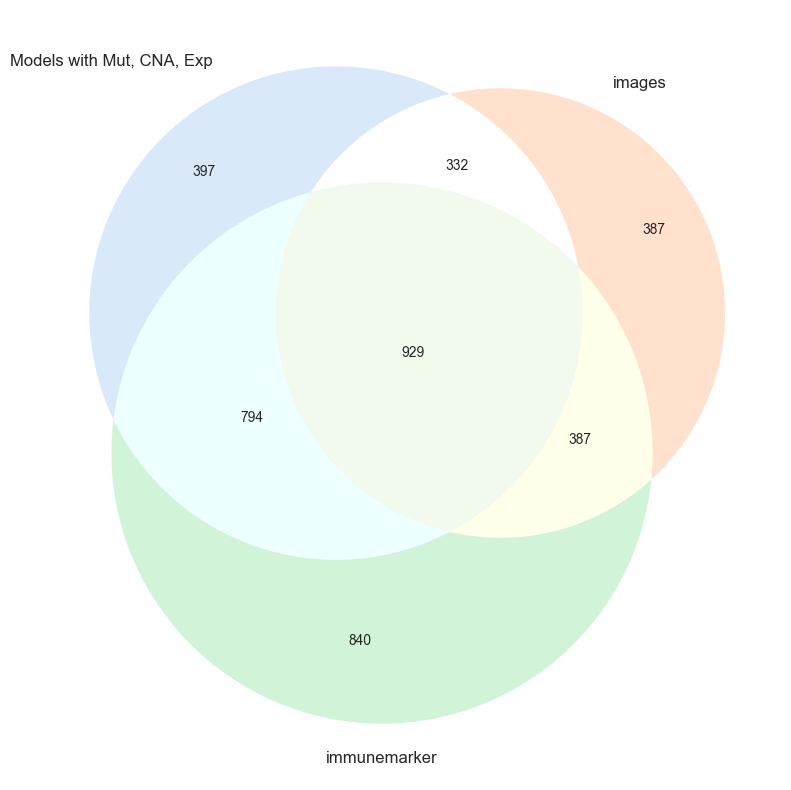

In [29]:
plt.figure(figsize=(10,10))
venn3([characterised_models, 
       set(model_molecular_types['images']), 
       set(model_molecular_types['immunemarker'])],
      set_labels=('Models with Mut, CNA, Exp', 'images', 'immunemarker'), set_colors=color_palette('pastel'))
plt.show()

In [44]:
all_model = characterised_models.intersection(set(model_molecular_types['images']), set(model_molecular_types['immunemarker']), set(model_molecular_types['biomarker']))

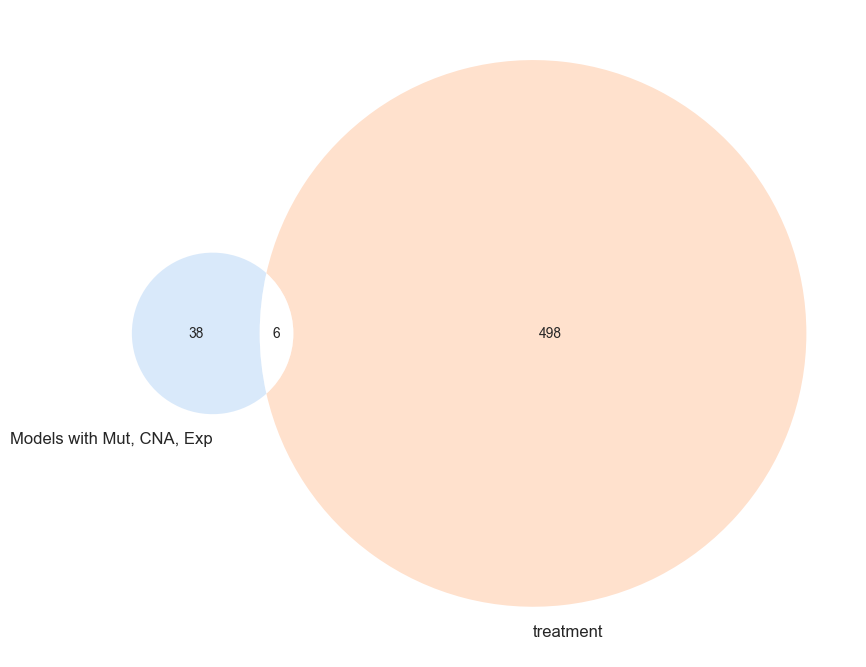

In [51]:

plt.figure(figsize=(10, 10))
venn2([all_model,
       set(model_molecular_types['treatment'])],
      set_labels=('Models with Mut, CNA, Exp', 'treatment'), set_colors=color_palette('pastel'))
plt.show()

In [41]:
len(all_model)

44

In [42]:
DataFrame(all_model)

,0
0,CRL-713
1,HCM-BROD-0648-C71
2,HCM-CSHL-0810-C54
3,CRL-574
4,HCM-CSHL-0729-C18
5,CRL-BR5
6,HCM-BROD-0614-C71
7,HCM-SANG-0277-C18
8,HCM-BROD-0209-C71
9,HCM-BROD-0681-C71


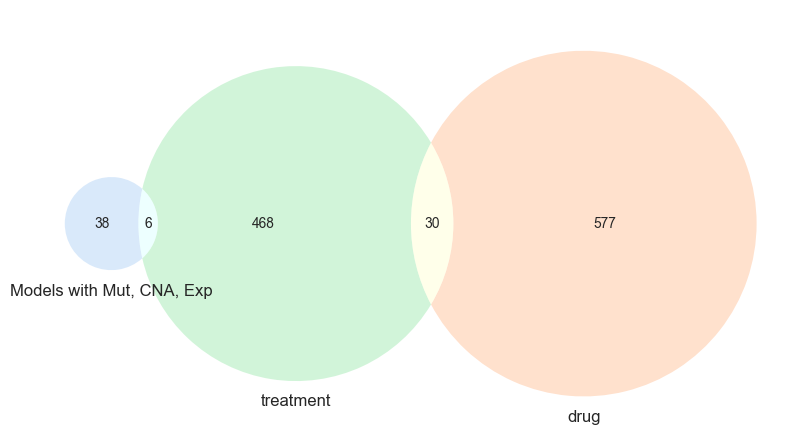

In [38]:
plt.figure(figsize=(10,10))
venn3([all_model, 
       set(model_molecular_types['drug']), 
       set(model_molecular_types['treatment'])],
      set_labels=('Models with Mut, CNA, Exp', 'drug', 'treatment'), set_colors=color_palette('pastel'))
plt.show()

In [39]:
DataFrame(all_model.intersection(set(model_molecular_types['treatment'])))

,0
0,CRL-1384
1,CRL-401
2,CRL-1322
3,CRL-508
4,CRL-583
5,CRL-2499


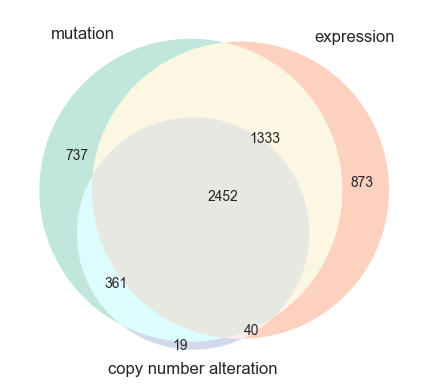

In [92]:
venn_result = venn3([set(model_molecular_types['mutation']), 
       set(model_molecular_types['expression']), 
       set(model_molecular_types['copy number alteration'])],
      set_labels=('mutation', 'expression', 'copy number alteration'), set_colors=color_palette('Set2'))

In [95]:
venn_result.get_patch_by_id('110')